In [ ]:
# added
!git clone https://github.com/manjunathshettar/fake-images

Cloning into 'fake-images'...
remote: Enumerating objects: 118692, done.
remote: Counting objects: 100% (118692/118692), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 118692 (delta 118655), reused 118689 (delta 118654), pack-reused 0
Receiving objects: 100% (118692/118692), 40.19 MiB | 34.84 MiB/s, done.
Resolving deltas: 100% (118655/118655), done.
Updating files: 100% (120007/120007), done.


In [1]:
# make sure to upload kaggle API token to get dataset directly from kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download birdy654/cifake-real-and-ai-generated-synthetic-images

 99% 103M/105M [00:00<00:00, 170MB/s] 
100% 105M/105M [00:00<00:00, 131MB/s]


In [6]:
!unzip cifake-real-and-ai-generated-synthetic-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# %matplotlib inline

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import inf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from torch.optim import lr_scheduler

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cpu')

In [10]:
img_height = 32
img_width = 32

In [11]:
import torchvision
from torchvision import transforms, datasets

In [12]:
transform = transforms.Compose([transforms.Resize((img_height, img_width)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [13]:
train_path = './train/'
train_path_real = './train/REAL/'
test_path = './test/'
test_path_real = './test/REAL/'

In [14]:
train_dataset = datasets.ImageFolder(root = train_path, transform=transform)
test_dataset = datasets.ImageFolder(root = test_path, transform=transform)

In [15]:
from torch.utils.data import DataLoader

In [16]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=True)    

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


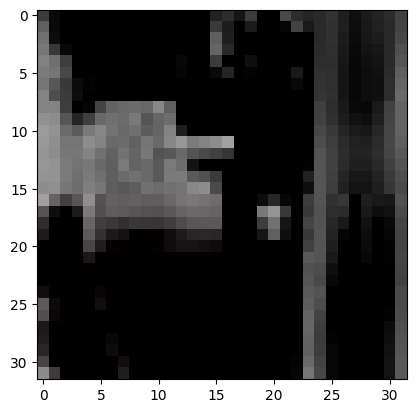

Label: 1


In [17]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img.transpose_(0, 2)
#display the image
plt.imshow(img, cmap="gray")
label = train_labels[1]
#plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [18]:
#split the datasets
from sklearn.model_selection import train_test_split

X_set, X_test, y_set, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_set, y_set, test_size=0.2, random_state=42)



In [19]:
#create a model

class Discriminator(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels = 32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels = 32, kernel_size=5)
        #self.conv = nn.Conv2d(in_channels=3, out_channels = 32, kernel_size=(3,3))

        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 1)

        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 5 * 5)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.squeeze()

In [20]:
discriminator = Discriminator().to(device)


In [21]:
print(X_train.shape, X_val.shape, X_test.shape)

torch.Size([40, 3, 32, 32]) torch.Size([11, 3, 32, 32]) torch.Size([13, 3, 32, 32])


In [22]:
#convert tensors to floats
X_train = X_train.float()
X_val = X_val.float()
X_test = X_test.float()
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

In [34]:
model = Discriminator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
accuracy_list = []

def train(epochs, model, perm=torch.arange(0, 784).long()):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, target) in enumerate(trainloader):
          # send to device
          data, target = data.to(device), target.to(device)
          
          data = data.float()
          target = target.float()

          optimizer.zero_grad()
          output = model(data)
          loss = F.binary_cross_entropy(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % 100 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(trainloader.dataset),
                  100. * batch_idx / len(trainloader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    y_pred = []
    y_test = []
    y_pred_raw = []
    for data, target in testloader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        data = data.float()
        target = target.float()
        # permute pixels
        output = model(data)
        test_loss += F.binary_cross_entropy(output, target, reduction='sum').item() # sum up batch loss 
        pred_raw = output                                                              
        pred = (output > 0.5).float()
        #print(pred)                                                               
        correct += (pred == target).cpu().sum().item()
        y_pred_raw.extend(pred_raw.detach().cpu().numpy())
        y_pred.extend(pred.detach().cpu().numpy())
        y_test.extend(target.detach().cpu().numpy())

    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    test_loss /= len(testloader.dataset)
    accuracy = 100. * correct / len(testloader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        accuracy))
    
    return y_pred_raw, y_pred, y_test
     


In [36]:
train(10, model) # 10 --> 94.45%

Train Epoch: 0 [0/100000 (0%)]	Loss: 0.689734
Train Epoch: 0 [6400/100000 (6%)]	Loss: 0.611399
Train Epoch: 0 [12800/100000 (13%)]	Loss: 0.465086
Train Epoch: 0 [19200/100000 (19%)]	Loss: 0.442885
Train Epoch: 0 [25600/100000 (26%)]	Loss: 0.359456
Train Epoch: 0 [32000/100000 (32%)]	Loss: 0.338916
Train Epoch: 0 [38400/100000 (38%)]	Loss: 0.367182
Train Epoch: 0 [44800/100000 (45%)]	Loss: 0.493893
Train Epoch: 0 [51200/100000 (51%)]	Loss: 0.363293
Train Epoch: 0 [57600/100000 (58%)]	Loss: 0.190570
Train Epoch: 0 [64000/100000 (64%)]	Loss: 0.155132
Train Epoch: 0 [70400/100000 (70%)]	Loss: 0.171676
Train Epoch: 0 [76800/100000 (77%)]	Loss: 0.237321
Train Epoch: 0 [83200/100000 (83%)]	Loss: 0.339031
Train Epoch: 0 [89600/100000 (90%)]	Loss: 0.205455
Train Epoch: 0 [96000/100000 (96%)]	Loss: 0.136584
Train Epoch: 1 [0/100000 (0%)]	Loss: 0.255917
Train Epoch: 1 [6400/100000 (6%)]	Loss: 0.177597
Train Epoch: 1 [12800/100000 (13%)]	Loss: 0.265641
Train Epoch: 1 [19200/100000 (19%)]	Loss: 0.1

In [37]:
y_pred_raw, y_pred, y_test = test(model)


Test set: Average loss: 0.1578, Accuracy: 18891/20000 (94.45%)



In [38]:
model_scripted = torch.jit.script(model)
torch.jit.save(model_scripted, "model.pt")

Evalution metrics: Accuracy, Precision, Recall, F1-score

In [39]:
def performance(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    metrics = {}
    metrics['accuracy'] = (tp+tn)/(tp+tn+fp+fn)
    metrics['precision'] = tp/(tp+fp)
    metrics['recall'] = tp/(tp+fn)
    metrics['f1-score'] = 2 * (metrics['precision']*metrics['recall']/
                                   (metrics['precision']+metrics['recall']))
    # output_dict['false_alarm'] = fp/(fp+tn)
    # output_dict['catch_rate'] = tp/(tp+fn)
    
    return conf_matrix, metrics

In [40]:
matrix, metrics = performance(y_test,y_pred)

Confusion matrix

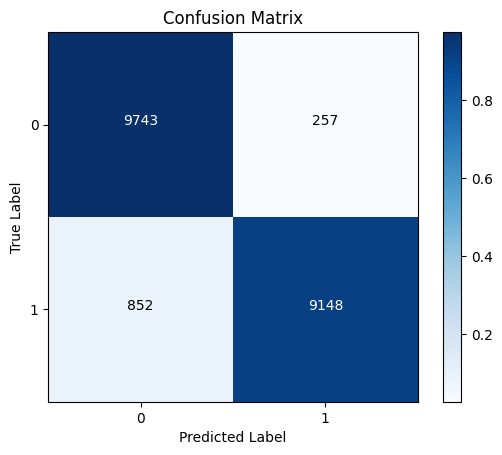

In [41]:
cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
num_classes = matrix.shape[0]
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add count values in each cell
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.show()


ROC curve, AUC

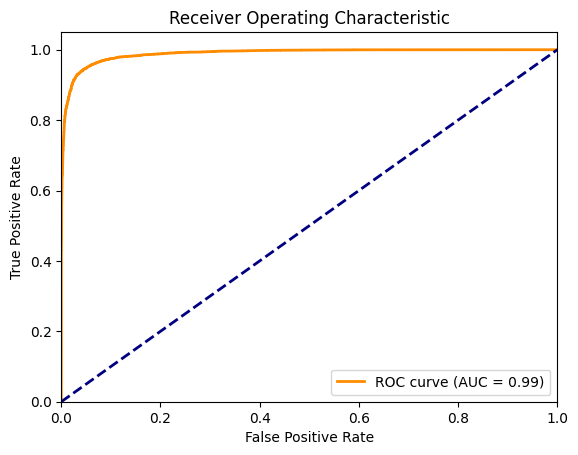

In [42]:
test_labels = test_dataset.targets

# # Convert the model predictions and true labels to NumPy arrays
model_predictions = np.array(y_pred_raw)
test_labels = np.array(y_test)

# Convert the model predictions and true labels to NumPy arrays
model_predictions = torch.from_numpy(model_predictions)
test_labels = torch.from_numpy(test_labels)

# Convert the tensors to float if they are not already
model_predictions = model_predictions.float()
test_labels = test_labels.float()

# Compute the False Positive Rate (fpr), True Positive Rate (tpr), and Thresholds
fpr, tpr, thresholds = roc_curve(test_labels, model_predictions)

# Compute the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [43]:
print(metrics)

{'accuracy': 0.94455, 'precision': 0.9726741095162148, 'recall': 0.9148, 'f1-score': 0.9428497809842823}
